In [1]:
import pandas as pd
import os, sys
from sklearn.gaussian_process import GaussianProcessRegressor
import shapefile
from functools import partial
import pyproj
from shapely.geometry import shape, Point, mapping
from shapely.ops import transform
processeddir = "../data/processed/"
rawdir = "../data/raw/"
df = pd.read_csv(os.path.join(processeddir,"nyctaxiclean.csv"), dtype={"store_and_fwd_flag": "object"})

In [2]:
df["pickup_float"] = pd.to_datetime(df["pickup_datetime"]).apply(lambda x: x.timestamp())
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])

In [31]:
df["trip_time_in_secs"].describe()

count    1.510163e+07
mean     7.466133e+02
std      5.505045e+02
min      0.000000e+00
25%      3.600000e+02
50%      6.000000e+02
75%      9.600000e+02
max      1.080000e+04
Name: trip_time_in_secs, dtype: float64

In [3]:
df["pickup_hour"] = df["pickup_datetime"].apply(lambda x: x.hour)
df["pickup_dayofweek"] = df["pickup_datetime"].apply(lambda x: x.weekday())
df["pickup_dayofmonth"] = df["pickup_datetime"].apply(lambda x: x.day)


In [29]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from sklearn.model_selection import KFold
# 4 POC neighbourhoods
chosen_neighbourhoods = ["Upper East Side South", "Midtown Center", "Flatiron", "JFK Airport"]
filtered_df = df[df["pickup_neighbourhood"].isin(chosen_neighbourhoods)]
# as this dataset is not aggregated we can use random 4-fold CV
kf = KFold(n_splits=4, shuffle=True)

kde_models = []
x_models = []
likelihood = []

filtered_df = filtered_df[["pickup_hour", "pickup_dayofweek", "trip_time_in_secs"]]
x_df = filtered_df[["pickup_hour", "pickup_dayofweek"]]

for train_index, test_index in list(kf.split(filtered_df))[:2]:
    train_df = filtered_df.iloc[train_index]
    test_df = filtered_df.iloc[test_index][:100]
    kde_models.append(KDEMultivariate(train_df, var_type='ooc'))
    x_models.append(KDEMultivariate(x_df, var_type='oo'))
   
    likelihood.append(np.exp(kde_models[-1].pdf(test_df))/np.exp(x_models[-1].pdf(test_df[["pickup_hour", "pickup_dayofweek"]])))

Text(0.5,0,'Test index')

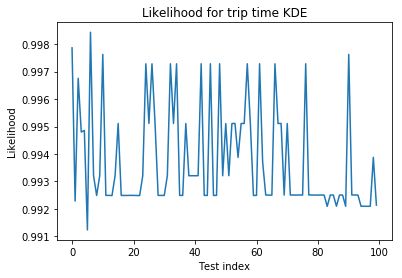

In [85]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
plt.plot(likelihood[0])
plt.title("Likelihood for trip time KDE")
plt.ylabel("Likelihood")
plt.xlabel("Test index")

#likelihood is sufficiently high for held out test set - 99-100%

In [71]:
#now assess some predictions
import numpy as np
triptime = np.linspace(0,960,25) #test up to 3rd percentile; no point assesing the long tail as
                                 #we're looking for short trips here

x_data = [[4, x] for x in range(24)]
yx_data = np.asarray([[x+[y] for x in x_data] for y in triptime])
x_data = np.asarray(x_data)
kde_time = kde_models[-1]
x_model = x_models[-1]

probs = []
for i in range(len(yx_data)):
    probs.append(np.exp(kde_time.cdf(yx_data[i])))

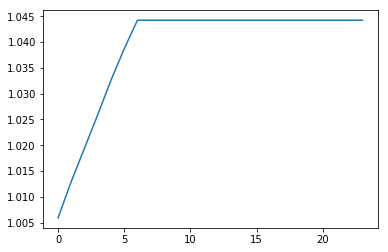

In [84]:
plt.plot(probs[18])